# Learning CStree using Gibbs sampler

In [241]:
import sys
import logging
import random

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq

import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
import pp

%load_ext autoreload
%autoreload 2
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
#logging.basicConfig(stream=sys.stderr, level=logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample a random CStree

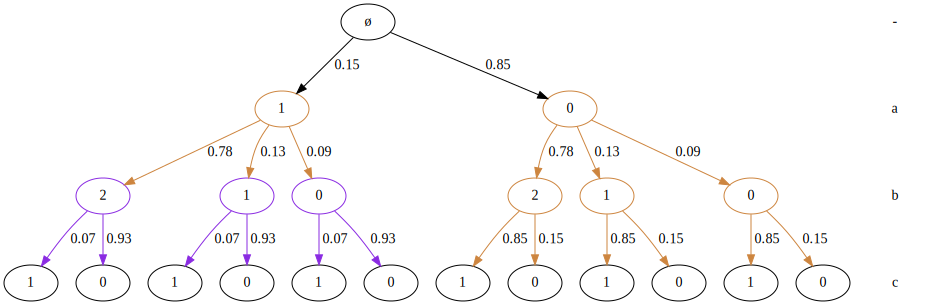

In [245]:
np.random.seed(2)
random.seed(2)
p = 3
cards = [2, 3, 2, 2, 2][:p] 

t = ct.sample_cstree(cards, max_cvars=2, prob_cvar=0.5, prop_nonsingleton=1)
t.labels = ["a", "b", "c", "d", "e"][:p]

t.plot(full=True)
t.sample_stage_parameters(alpha=2) # optimize parameters 
t.plot(full=True)

In [246]:
agraphs= t.to_minimal_context_agraphs()
print(len(agraphs))

cstree.py:to_minimal_context_csis (387):  Stages
cstree.py:to_minimal_context_csis (390):  level 0
cstree.py:to_minimal_context_csis (392):  [{0, 1}]; probs: [0.08879013 0.13254952 0.77866035]; color: peru
cstree.py:to_minimal_context_csis (390):  level 1
cstree.py:to_minimal_context_csis (392):  [0, {0, 1, 2}]; probs: [0.1459822 0.8540178]; color: peru
cstree.py:to_minimal_context_csis (392):  [1, {0, 1, 2}]; probs: [0.92873983 0.07126017]; color: blueviolet
cstree.py:to_minimal_context_csis (390):  level 2
cstree.py:to_minimal_context_csis (390):  level -1
cstree.py:to_minimal_context_csis (392):  []; probs: [0.84749768 0.15250232]; color: black
cstree.py:to_minimal_context_csis (393):  Getting csi rels per level
cstree.py:to_minimal_context_csis (395):  CSI relations per level
cstree.py:to_minimal_context_csis (398):  level 0: 
cstree.py:to_minimal_context_csis (401):  the CSI
cstree.py:to_minimal_context_csis (402):  X0 ⊥ X1
cstree.py:to_minimal_context_csis (403):  cards: [2, 3, 2

csi_relation.py:minimal_csis (682):  Updating mix results by removing if they already are in oldies, or a subset of an oldie.
csi_relation.py:minimal_csis (700):  newbies (new mixes after the filtering):
csi_relation.py:minimal_csis (703):  oldies
csi_relation.py:minimal_csis (705):  [None, None]
csi_relation.py:minimal_csis (571):  
#### Level 1
csi_relation.py:minimal_csis (581):  
#### Iteration 1
csi_relation.py:minimal_csis (589):  level 0
csi_relation.py:partition_csis (468):  Partitioning CSIs
csi_relation.py:partition_csis (469):  level 0
csi_relation.py:partition_csis (470):  cards [2, 3, 2]
csi_relation.py:partition_csis (471):  [[{0}, None, None], [{1}, None, None]]
csi_relation.py:partition_csis (478):  var_val 0
csi_relation.py:partition_csis (478):  var_val 1
csi_relation.py:minimal_csis (627):  mixing
csi_relation.py:minimal_csis (628):  ([{0}, None, None], [{1}, None, None])
csi_relation.py:minimal_csis (629):  mix result: 
csi_relation.py:minimal_csis (630):  [{0, 1}, 

1


None


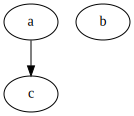

In [249]:
keys = list(agraphs.keys())
print(keys[0])
agraphs[keys[0]]


In [250]:
keys = list(agraphs.keys())
print(keys[1])
agraphs[keys[1]]


IndexError: list index out of range

In [218]:
np.random.seed(6)
x = t.sample(2000)
x

,a,b,c,d
0,2,3,2,2
1,0,1,1,1
2,1,0,0,1
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
1996,1,0,0,1
1997,0,2,1,0
1998,1,0,1,1
1999,1,1,1,1


In [219]:
x.to_csv("data.csv", index=False)

## Create the score tables

In [220]:
pcgraph = pc(x[1:].values, 0.05, "chisq", node_names=x.columns)
#print(pcgraph.find_adj()) # can take such as input. or an adjmat

poss_cvars = {l:[] for l in x.columns}
for (i, j) in pcgraph.find_adj():
    poss_cvars[x.columns[i]].append(x.columns[j])
#poss_cvars


Depth=2, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 266.22it/s]


In [221]:
#poss_cvars = {l:random.sample(list(set(t.labels) - {l}) ,k=3) for l in t.labels}
#poss_cvars = None
print(poss_cvars)

{'a': ['b', 'c', 'd'], 'b': ['a', 'd'], 'c': ['a'], 'd': ['a', 'b']}


In [222]:
score_table, context_scores, context_counts = sc.order_score_tables(x, 
                                                                    max_cvars=2, 
                                                                    alpha_tot=1.0,
                                                                    method="BDeu",
                                                                    poss_cvars=poss_cvars)

Context score tables:  50%|█████     | 2/4 [00:00<00:00, 19.90it/s]

Order score tables: 100%|██████████| 4/4 [00:00<00:00, 137.17it/s]


## The order score tables

In [223]:
pp(score_table)

{'max_cvars': 2,
 'poss_cvars': {'a': ['b', 'c', 'd'],
                'b': ['a', 'd'],
                'c': ['a'],
                'd': ['a', 'b']},
 'scores': {'a': {'None': -1204.299941026929,
                  'b': -1198.0920940798947,
                  'b,c': -839.0180438566807,
                  'b,c,d': -839.3282404119066,
                  'b,d': -1146.6261733937426,
                  'c': -841.4174845495138,
                  'c,d': -839.7021131280314,
                  'd': -1196.3326129425436},
            'b': {'None': -2050.849774967432,
                  'a': -2044.6419280203975,
                  'a,d': -1987.129274724707,
                  'd': -2046.6071487002584},
            'c': {'None': -1378.4527187704775, 'a': -1015.5702622930623},
            'd': {'None': -1383.0455129233483,
                  'a': -1375.0781848389624,
                  'a,b': -1317.9698724285877,
                  'b': -1378.8028866561751}}}


## The context score tables

In [224]:
pp(context_scores)

{'cards': {'a': 2, 'b': 3, 'c': 2, 'd': 2},
 'max_cvars': 2,
 'poss_cvars': {'a': ['b', 'c', 'd'],
                'b': ['a', 'd'],
                'c': ['a'],
                'd': ['a', 'b']},
 'scores': {'a': {'None': -1202.9136466658092,
                  'b=0': -577.2254557545175,
                  'b=0,c=0': -31.152054240015428,
                  'b=0,c=1': -388.2724419058361,
                  'b=0,d=0': -155.36598069919316,
                  'b=0,d=1': -387.9490306760903,
                  'b=1': -378.5313335784572,
                  'b=1,c=0': -19.09779247272217,
                  'b=1,c=1': -230.24721190159488,
                  'b=1,d=0': -151.4783458965712,
                  'b=1,d=1': -225.25406028771988,
                  'b=2': -240.54488855823547,
                  'b=2,c=0': -18.44422992574902,
                  'b=2,c=1': -154.77110653175885,
                  'b=2,d=0': -157.73309527681727,
                  'b=2,d=1': -65.82073660053405,
                  'c=0': -62.

## Run the Gibbs sampler

In [225]:
orders, scores = ctl.gibbs_order_sampler(5000, score_table)

initial order: ['b', 'a', 'd', 'c']
initial score: -5582.482003768977


Gibbs order sampler:   6%|▌         | 277/5000 [00:00<00:01, 2767.92it/s]

Gibbs order sampler: 100%|██████████| 5000/5000 [00:01<00:00, 3899.03it/s]


### Trajectory score plots

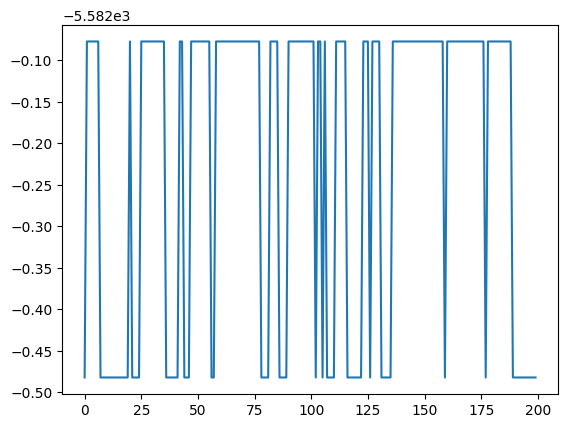

In [226]:
plt.plot(scores[:200])

### Order position plots

Get the individual variables locations in the order and plot them

In [227]:
var_positions = {var: [x.index(var) for x in orders] for var in orders[0]}
var_positions["iteration"] = list(range(len(orders))) 
plotdf = pd.DataFrame(var_positions)

<Axes: xlabel='iteration'>

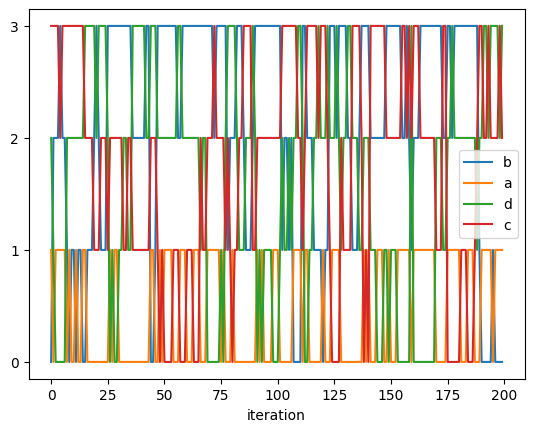

In [228]:
plotdf[:200].plot(x = "iteration", y = range(p), yticks=range(len(orders[0])))

### Get the maximal scoring order

In [229]:
max(scores)
maxi = scores.index(max(scores))
maporder = orders[maxi]
maporder

['a', 'c', 'd', 'b']

### Get the maximal scoring CStree for the order

In [230]:
opttree = ctl._optimal_cstree_given_order(maporder, context_scores)

In [231]:
opttree.to_df()

,a,c,d,b
0,2,2,2,3
1,0,-,-,-
2,1,-,-,-
3,0,*,-,-
4,1,*,-,-
5,0,*,0,-
6,0,*,1,-
7,1,*,*,-
8,-,-,-,-


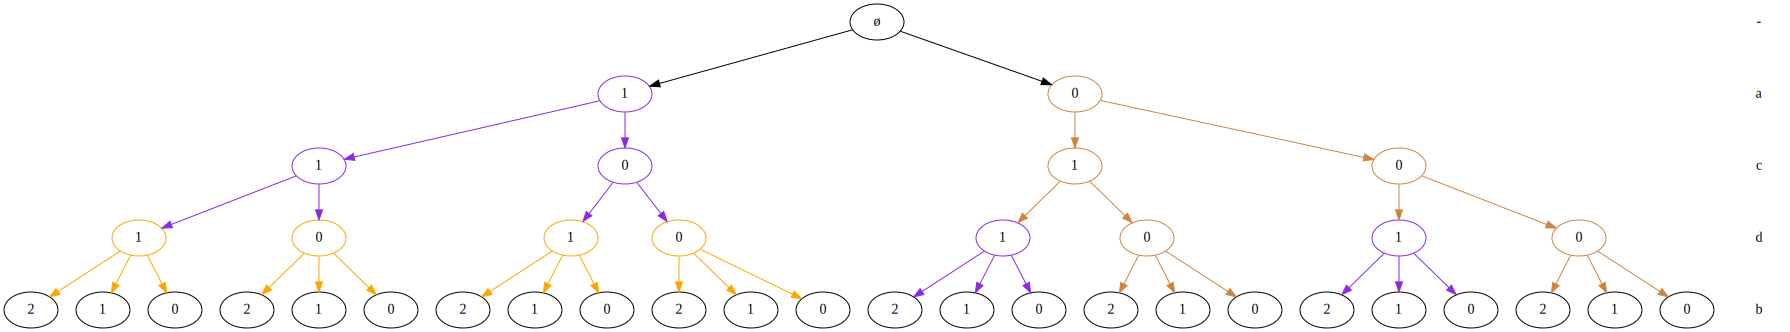

In [232]:
opttree.plot(full=True)

## Estimate the CStree parameters

In [233]:
opttree.estimate_stage_parameters(x, alpha_tot=2.0, method="BDeu")

opttree.to_df(write_probs=True)


,a,c,d,b,PROB_0,PROB_1,PROB_2
0,2,2,2,3,NaN,NaN,NaN
1,0,-,-,-,0.020000,0.980000,NaN
2,1,-,-,-,0.612824,0.387176,NaN
3,0,*,-,-,0.366087,0.633913,NaN
4,1,*,-,-,0.488788,0.511212,NaN
5,0,*,0,-,0.228820,0.338084,0.433096
6,0,*,1,-,0.557385,0.387289,0.055327
7,1,*,*,-,0.548236,0.248306,0.203457
8,-,-,-,-,0.287213,0.712787,NaN


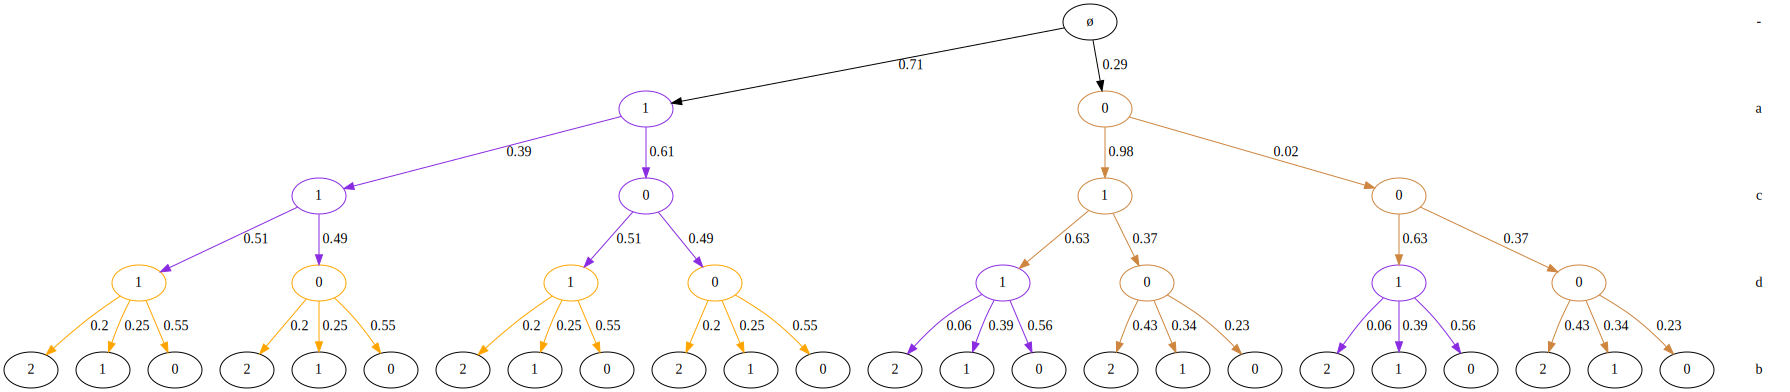

In [234]:
opttree.plot(full=True)

## Plot the DAG representation

In [235]:
agraphs= opttree.to_minimal_context_agraphs()
len(agraphs)

cstree.py:to_minimal_context_csis (387):  Stages
cstree.py:to_minimal_context_csis (390):  level 0
cstree.py:to_minimal_context_csis (392):  [0]; probs: [0.02, 0.98]; color: peru
cstree.py:to_minimal_context_csis (392):  [1]; probs: [0.6128241065171689, 0.3871758934828311]; color: blueviolet
cstree.py:to_minimal_context_csis (390):  level 1
cstree.py:to_minimal_context_csis (392):  [0, {0, 1}]; probs: [0.3660869565217391, 0.6339130434782608]; color: peru
cstree.py:to_minimal_context_csis (392):  [1, {0, 1}]; probs: [0.48878766643307636, 0.5112123335669236]; color: blueviolet
cstree.py:to_minimal_context_csis (390):  level 2
cstree.py:to_minimal_context_csis (392):  [0, {0, 1}, 0]; probs: [0.2288202692003167, 0.33808392715756136, 0.43309580364212197]; color: peru
cstree.py:to_minimal_context_csis (392):  [0, {0, 1}, 1]; probs: [0.557384545038866, 0.3872885230909922, 0.05532693187014175]; color: blueviolet
cstree.py:to_minimal_context_csis (392):  [1, {0, 1}, {0, 1}]; probs: [0.548236393

cstree.py:to_minimal_context_csis (402):  X1 ⊥ X2, X0=1
cstree.py:to_minimal_context_csis (403):  cards: [2, 2, 2, 3]
cstree.py:to_minimal_context_csis (398):  level 2: 
cstree.py:to_minimal_context_csis (401):  the CSI
cstree.py:to_minimal_context_csis (402):  X1 ⊥ X3, X0=0, X2=0
cstree.py:to_minimal_context_csis (403):  cards: [2, 2, 2, 3]
cstree.py:to_minimal_context_csis (401):  the CSI
cstree.py:to_minimal_context_csis (402):  X1 ⊥ X3, X0=0, X2=1
cstree.py:to_minimal_context_csis (403):  cards: [2, 2, 2, 3]
cstree.py:to_minimal_context_csis (401):  the CSI
cstree.py:to_minimal_context_csis (402):  X1, X2 ⊥ X3, X0=1
cstree.py:to_minimal_context_csis (403):  cards: [2, 2, 2, 3]
cstree.py:to_minimal_context_csis (398):  level 3: 
csi_relation.py:pairwise_csis (392):  Pairwise CSIs
csi_relation.py:pairwise_csis (392):  Pairwise CSIs
csi_relation.py:pairwise_csis (392):  Pairwise CSIs
csi_relation.py:pairwise_csis (392):  Pairwise CSIs
csi_relation.py:as_list (158):  Pairwise CSI as a 

2

None


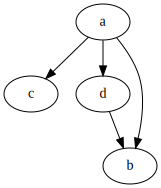

In [236]:
keys = list(agraphs.keys())
print(keys[0])
agraphs[keys[0]]
